In [1]:
import math
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from math import log10

[Matteo-Device:69515] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/2820341760/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:69515] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
fuel=openmc.Material(name='fuel')
fuel.add_nuclide('U235',1.0)
fuel.set_density('g/cm3',10)
fuel.depletable=True

fuel2=openmc.Material(name='fuel2')
fuel2.add_nuclide('U238',1)
fuel2.set_density('g/cm3',10)
fuel.depletable=True

water=openmc.Material(name='water')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

mats=openmc.Materials((fuel,fuel2,water))
mats.export_to_xml()

In [3]:
r_pin=openmc.ZCylinder(r=0.25)
fuel_cell=openmc.Cell(fill=fuel, region=-r_pin)
water_cell=openmc.Cell(fill=fuel , region=+r_pin)
pin_universe=openmc.Universe(cells=(fuel_cell, water_cell))

r_big_pin = openmc.ZCylinder(r=0.5)
fuel2_cell = openmc.Cell(fill=fuel2, region=-r_big_pin)
water2_cell = openmc.Cell(fill=water, region=+r_big_pin)
big_pin_universe = openmc.Universe(cells=(fuel2_cell, water2_cell))

all_water_cell=openmc.Cell(fill=water)
outer_universe=openmc.Universe(cells=(all_water_cell,))

In [4]:
lat=openmc.HexLattice()

In [5]:
lat.center=(0.,0.)
lat.pitch=(1.25,)
lat.outer=outer_universe

In [6]:
print(lat.show_indices(3))

            (0, 0)
      (0,11)      (0, 1)
(0,10)      (1, 0)      (0, 2)
      (1, 5)      (1, 1)
(0, 9)      (2, 0)      (0, 3)
      (1, 4)      (1, 2)
(0, 8)      (1, 3)      (0, 4)
      (0, 7)      (0, 5)
            (0, 6)


In [7]:
outer_rig=[big_pin_universe]+[pin_universe]*11
middle_rig=[big_pin_universe]+[pin_universe]*5
inner_rig=[big_pin_universe]
lat.universes=[outer_rig,middle_rig,inner_rig]
print(lat)

HexLattice
	ID             =	4
	Name           =	
	Orientation    =	y
	# Rings        =	3
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.25,)
	Outer          =	3
	Universes      
  2
 1 1
1 2 1
 1 1
1 2 1
 1 1
1 1 1
 1 1
  1


In [8]:
outer_surface=openmc.ZCylinder(r=4.0,boundary_type='vacuum')
main_cell=openmc.Cell(fill=lat, region=-outer_surface)
geom=openmc.Geometry([main_cell])
geom.export_to_xml()

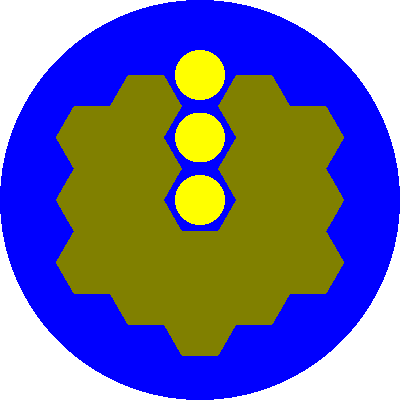

In [9]:
p=openmc.Plot.from_geometry(geom)
p.color_by='material'
p.colors = colors = {
    water: 'blue',
    fuel: 'olive',
    fuel2: 'yellow'
}
p.to_ipython_image()

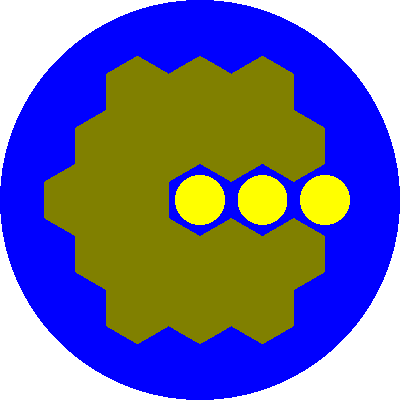

In [10]:
# Change the orientation of the lattice and re-export the geometry
lat.orientation = 'x'
geom.export_to_xml()

# Run OpenMC in plotting mode
p.to_ipython_image()

/home/orion/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


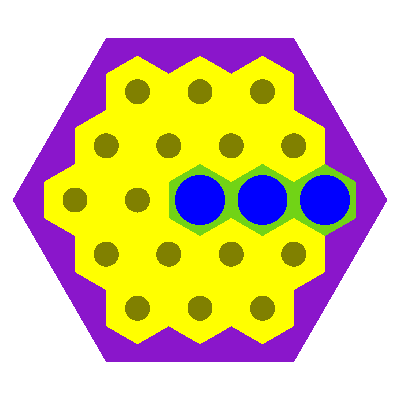

In [11]:
main_cell.region = openmc.model.hexagonal_prism(
    edge_length=3*lat.pitch[0],
    orientation='x',
    boundary_type='vacuum'
)
geom.export_to_xml()

# Run OpenMC in plotting mode
p.color_by = 'cell'
p.to_ipython_image()

In [12]:
settings = openmc.Settings()
settings.particles = 100
settings.inactive = 10
settings.batches = 50

In [13]:
fuel.volume = math.pi * 0.25 ** 2
fuel2.volume = math.pi * (0.5-0.25) ** 2

In [17]:
chain = openmc.deplete.Chain.from_xml("../chain_endfb80_sfr.xml")
#chain.nuclide_dict

In [20]:
model = openmc.Model(geometry=geom, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "../chain_endfb80_sfr.xml")

In [21]:
power = 210
time_steps = [30] * 6

In [ ]:
integrator.integrate()